# Prediction of J1939 Protocol Data Using LSTM Neural Networks

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import textwrap
import glob
import re

## Import Dataset

In [2]:
# Load all data from multiple PGN CSV files. This data requires some cleanup.
df_list = []
for file in glob.glob('/s/bach/h/proj/HeavyVehicle/Phishing/Adversarial/heav/10-Dataset/Deciphered/TU36_002_1*.csv'):
    df_pgn = pd.read_csv(file, index_col=1)
    # Column names in the csv files need to have whitespace trimmed
    df_pgn.columns = [col.strip().split(":")[-1] for col in df_pgn]
    # Remove unwanted columns
    df_pgn = df_pgn.drop(columns=['RowId', 'TimeInterval', 'Difference', 'Label'])
    df_list.append(df_pgn)

# Create whole dataframe
df = pd.concat(df_list, axis=1)

# Eliminate duplicated columns
df = df.groupby(df.columns, axis=1).agg(np.nanmax)

# Reindex
df.set_index(df.index.astype(float) - df.index.astype(float).min(), inplace=True)

# Remove columns without enough unique values
for spn in df:
    if len(df[spn].unique()) < 50:
        df = df.drop(spn,axis=1)

## Import J1939DA "Digital Annex"

In [3]:
# Load J1939 Digital Annex
annex = pd.read_csv('/s/bach/h/proj/HeavyVehicle/Phishing/Adversarial/heav/10-Dataset/DigitalAnnex-J1939.csv', index_col='SPN')
annex = annex.drop(annex.columns[0], axis=1)

# Only keep SPNs for our dataset
annex = annex[annex.index.isin(df.columns)]

In [4]:
def get_SPN_name(spn):
    '''Helper function to get useful string names for SPNs'''
    spn = int(spn)
    spn_name = annex.loc[spn]['SPNName']
    substring = re.search('\d\s*(.*)$', spn_name)
    if substring:
        spn_name = substring.group(1)
        
    return spn_name

## Select SPNs

In [5]:
# Select 100ms and 500ms SPNs
spns_100ms = annex[annex['TransmitionRate'] == '100 ms'].index.astype(str).tolist()
spns_500ms = annex[(annex['TransmitionRate'] == '500 ms') | (annex['TransmitionRate'] == '0.5 s') ].index.astype(str).tolist()
spns = spns_100ms + spns_500ms
# Add RPM
spns += ['190']
# Remove duplicate vehicle speed
spns -= ['904']

# Only keep data from our SPNS
annex = annex[annex.index.isin(spns)]
df = df[spns].dropna(thresh=1)

## Re-Sample Data at 500ms Interval

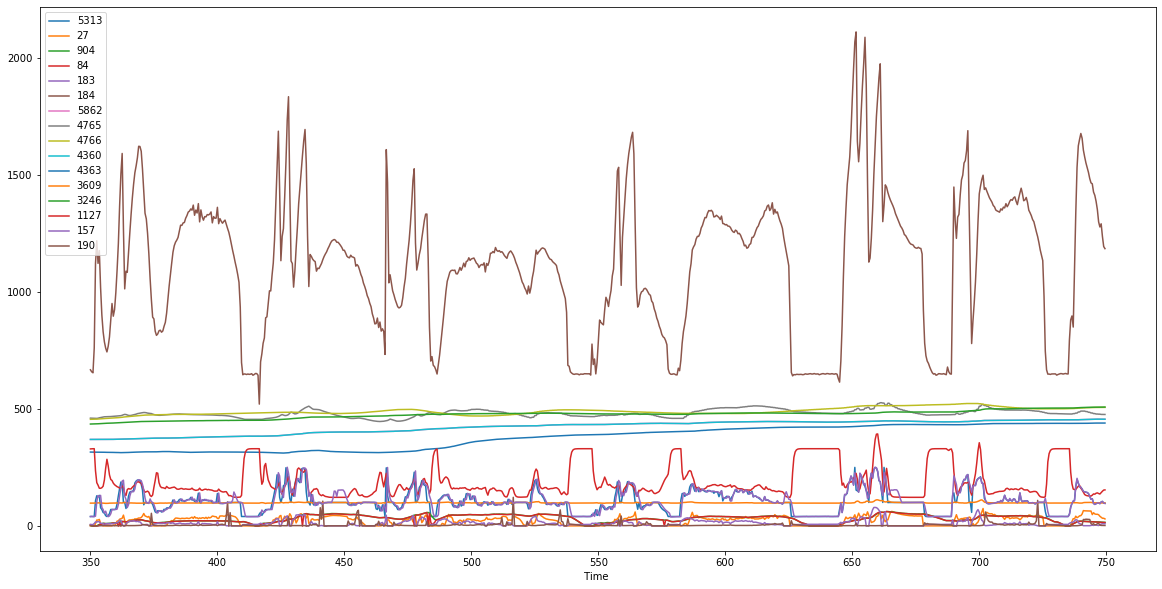

In [6]:
# Reindex SPNs to 500ms intervals
df = df.ffill().reindex(np.arange(350, 750, 0.5), method='ffill')

df.plot(figsize=(20,10))

## Extrapolation Experiments

In [7]:
def extrapolate(df, extrap_fn):
    '''Perform stepwise extrapolation for each SPN.'''
    df_extrap = df.copy()
    for i in range(2, len(df)):
        df_tmp = df.iloc[:i+1].copy()
        df_tmp.iloc[i] = np.nan
        df_tmp = df_tmp.interpolate(method=extrap_fn, fill_value='extrapolate')
        df_extrap.iloc[i] = df_tmp.iloc[i]
        
    return df_extrap

In [8]:
# Perform three different forms of stepwise extrapolation and group with real data
# 1. Repeat previous value
# 2. Linear extrapolation
# 3. PCHIP extrapolation
df_extrap = pd.concat(
    [df, extrapolate(df, 'linear'), extrapolate(df, 'slinear'), extrapolate(df, 'pchip')],
    keys=['Actual', 'Repeat', 'Linear', 'PCHIP'],
    names=['Method'],
    axis=1)
df_extrap.columns.names = ['Method', 'SPN']

### Extrapolation Example: SPN 1127 Boost Pressure

Text(0.5, 0, 'Time (s)')

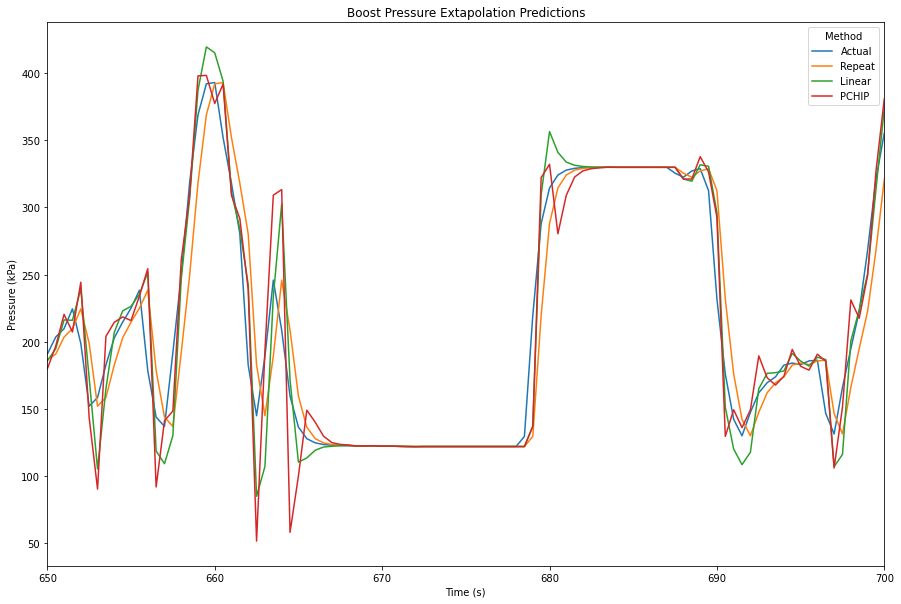

In [9]:
ax = df_extrap.xs('1127', level='SPN', axis=1).plot(figsize=(15,10))
ax.set_xlim(650,700)
ax.set_title('Boost Pressure Extapolation Predictions')
ax.set_ylabel('Pressure (kPa)')
ax.set_xlabel('Time (s)')

## LSTM Models

In [12]:
def lstm_model(input_shape, dropout=0):
    '''Generate LSTM model'''
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(64, input_shape=input_shape, dropout=dropout, recurrent_dropout=dropout, return_sequences=True))
    model.add(tf.keras.layers.LSTM(32, dropout=dropout, recurrent_dropout=dropout, return_sequences=False))
    model.add(tf.keras.layers.Dense(1))
    return model

### Train LSTM Models

In [13]:
from sklearn.preprocessing import MinMaxScaler

def train_model(model, df_train, spn_in, spn_target, filepath, batch_size=50, loss='mse', verbose=False, epochs=1000):
    '''Train time series models.

    Models will be saved to filepath.
    '''
    # Normalize data
    scaler_in = MinMaxScaler()
    scaler_out = MinMaxScaler()

    scaled_in = scaler_in.fit_transform(df_train[spn_in])
    scaled_target = scaler_out.fit_transform(df_train[spn_target])

    # Calculate train test data split
    test_split_index = int(len(scaled_target) * 0.75)

    # Create time series sequences
    train_seq = tf.keras.preprocessing.sequence.TimeseriesGenerator(
        scaled_in, scaled_target, 1, sampling_rate=1, stride=1, start_index=0,
        end_index=test_split_index, shuffle=True, reverse=False, batch_size=batch_size
    )
    test_seq = tf.keras.preprocessing.sequence.TimeseriesGenerator(
        scaled_in, scaled_target, 1, sampling_rate=1, stride=1, start_index=test_split_index,
        end_index=None, shuffle=False, reverse=False, batch_size=batch_size
    )
    
    # Compile model
    model.compile(loss=loss, optimizer='adam')

    # Configure callbacks    
    rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=0.001)
    cp = tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=filepath, save_best_only=True)
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

    # Fit model
    history = model.fit(train_seq, epochs=epochs, validation_data=test_seq, verbose=verbose,callbacks=[cp])
    
    return history

In [26]:
# Train a model for each SPN sampled at 500ms
for spn in spns:
    tf.keras.backend.clear_session()
    model = lstm_model((1, len(df.columns)))
    filepath = f'models/LSTM_{spn}'
    print(f'Training model for SPN: {spn}')
    print(f'Save to {filepath}')
    train_model(model, df, df.columns, [spn], filepath)

Training model for SPN: 5313
Save to models/LSTM_5313
INFO:tensorflow:Assets written to: models/LSTM_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_5313/assets
IN

INFO:tensorflow:Assets written to: models/LSTM_84/assets
INFO:tensorflow:Assets written to: models/LSTM_84/assets
INFO:tensorflow:Assets written to: models/LSTM_84/assets
INFO:tensorflow:Assets written to: models/LSTM_84/assets
INFO:tensorflow:Assets written to: models/LSTM_84/assets
INFO:tensorflow:Assets written to: models/LSTM_84/assets
INFO:tensorflow:Assets written to: models/LSTM_84/assets
INFO:tensorflow:Assets written to: models/LSTM_84/assets
INFO:tensorflow:Assets written to: models/LSTM_84/assets
INFO:tensorflow:Assets written to: models/LSTM_84/assets
INFO:tensorflow:Assets written to: models/LSTM_84/assets
Training model for SPN: 183
Save to models/LSTM_183
INFO:tensorflow:Assets written to: models/LSTM_183/assets
INFO:tensorflow:Assets written to: models/LSTM_183/assets
INFO:tensorflow:Assets written to: models/LSTM_183/assets
INFO:tensorflow:Assets written to: models/LSTM_183/assets
INFO:tensorflow:Assets written to: models/LSTM_183/assets
INFO:tensorflow:Assets written 

INFO:tensorflow:Assets written to: models/LSTM_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_5862/asse

INFO:tensorflow:Assets written to: models/LSTM_4360/assets
INFO:tensorflow:Assets written to: models/LSTM_4360/assets
INFO:tensorflow:Assets written to: models/LSTM_4360/assets
INFO:tensorflow:Assets written to: models/LSTM_4360/assets
INFO:tensorflow:Assets written to: models/LSTM_4360/assets
INFO:tensorflow:Assets written to: models/LSTM_4360/assets
INFO:tensorflow:Assets written to: models/LSTM_4360/assets
INFO:tensorflow:Assets written to: models/LSTM_4360/assets
INFO:tensorflow:Assets written to: models/LSTM_4360/assets
INFO:tensorflow:Assets written to: models/LSTM_4360/assets
INFO:tensorflow:Assets written to: models/LSTM_4360/assets
INFO:tensorflow:Assets written to: models/LSTM_4360/assets
INFO:tensorflow:Assets written to: models/LSTM_4360/assets
INFO:tensorflow:Assets written to: models/LSTM_4360/assets
INFO:tensorflow:Assets written to: models/LSTM_4360/assets
INFO:tensorflow:Assets written to: models/LSTM_4360/assets
INFO:tensorflow:Assets written to: models/LSTM_4360/asse

INFO:tensorflow:Assets written to: models/LSTM_3609/assets
INFO:tensorflow:Assets written to: models/LSTM_3609/assets
INFO:tensorflow:Assets written to: models/LSTM_3609/assets
INFO:tensorflow:Assets written to: models/LSTM_3609/assets
Training model for SPN: 3246
Save to models/LSTM_3246
INFO:tensorflow:Assets written to: models/LSTM_3246/assets
INFO:tensorflow:Assets written to: models/LSTM_3246/assets
INFO:tensorflow:Assets written to: models/LSTM_3246/assets
INFO:tensorflow:Assets written to: models/LSTM_3246/assets
INFO:tensorflow:Assets written to: models/LSTM_3246/assets
INFO:tensorflow:Assets written to: models/LSTM_3246/assets
INFO:tensorflow:Assets written to: models/LSTM_3246/assets
INFO:tensorflow:Assets written to: models/LSTM_3246/assets
INFO:tensorflow:Assets written to: models/LSTM_3246/assets
INFO:tensorflow:Assets written to: models/LSTM_3246/assets
INFO:tensorflow:Assets written to: models/LSTM_3246/assets
INFO:tensorflow:Assets written to: models/LSTM_3246/assets
IN

INFO:tensorflow:Assets written to: models/LSTM_157/assets
INFO:tensorflow:Assets written to: models/LSTM_157/assets
INFO:tensorflow:Assets written to: models/LSTM_157/assets
INFO:tensorflow:Assets written to: models/LSTM_157/assets
INFO:tensorflow:Assets written to: models/LSTM_157/assets
INFO:tensorflow:Assets written to: models/LSTM_157/assets
INFO:tensorflow:Assets written to: models/LSTM_157/assets
INFO:tensorflow:Assets written to: models/LSTM_157/assets
INFO:tensorflow:Assets written to: models/LSTM_157/assets
INFO:tensorflow:Assets written to: models/LSTM_157/assets
INFO:tensorflow:Assets written to: models/LSTM_157/assets
INFO:tensorflow:Assets written to: models/LSTM_157/assets
INFO:tensorflow:Assets written to: models/LSTM_157/assets
INFO:tensorflow:Assets written to: models/LSTM_157/assets
INFO:tensorflow:Assets written to: models/LSTM_157/assets
INFO:tensorflow:Assets written to: models/LSTM_157/assets
INFO:tensorflow:Assets written to: models/LSTM_157/assets
INFO:tensorflo

### LSTM Model Predictions

In [14]:
def eval_model(df, spn_in, spn_target, filepath, batch_size=50):
    # Normalize data
    scaler_in = MinMaxScaler()
    scaler_out = MinMaxScaler()

    scaled_in = scaler_in.fit_transform(df[spn_in])
    scaled_target = scaler_out.fit_transform(df[spn_target])

    # Load best weights
    model = tf.keras.models.load_model(filepath)
    
    # Evaluate model
    seq = tf.keras.preprocessing.sequence.TimeseriesGenerator(
        scaled_in, scaled_target, 1, sampling_rate=1, stride=1, start_index=0,
        end_index=None, shuffle=False, reverse=False, batch_size=batch_size)
    Ystd = model.predict(seq)
    Y = scaler_out.inverse_transform(Ystd)
    
    return Y

In [15]:
# Evaluate model for each SPN
Ys = []
for spn in spns:
    filepath = f'models/LSTM_{spn}'
    
    # Generate model prediction
    tf.keras.backend.clear_session()
    Y = eval_model(df, df.columns, [spn], filepath)
    Ys.append(Y)

df_lstm = pd.DataFrame(np.hstack(Ys), index=df.index[1:], columns=spns)

# Add LSTM predictions to our extrapolation dataframe
df_extrap = pd.concat([df_extrap, df_lstm.set_axis(pd.MultiIndex.from_product([['LSTM'],df_lstm.columns]), axis=1)], axis=1)

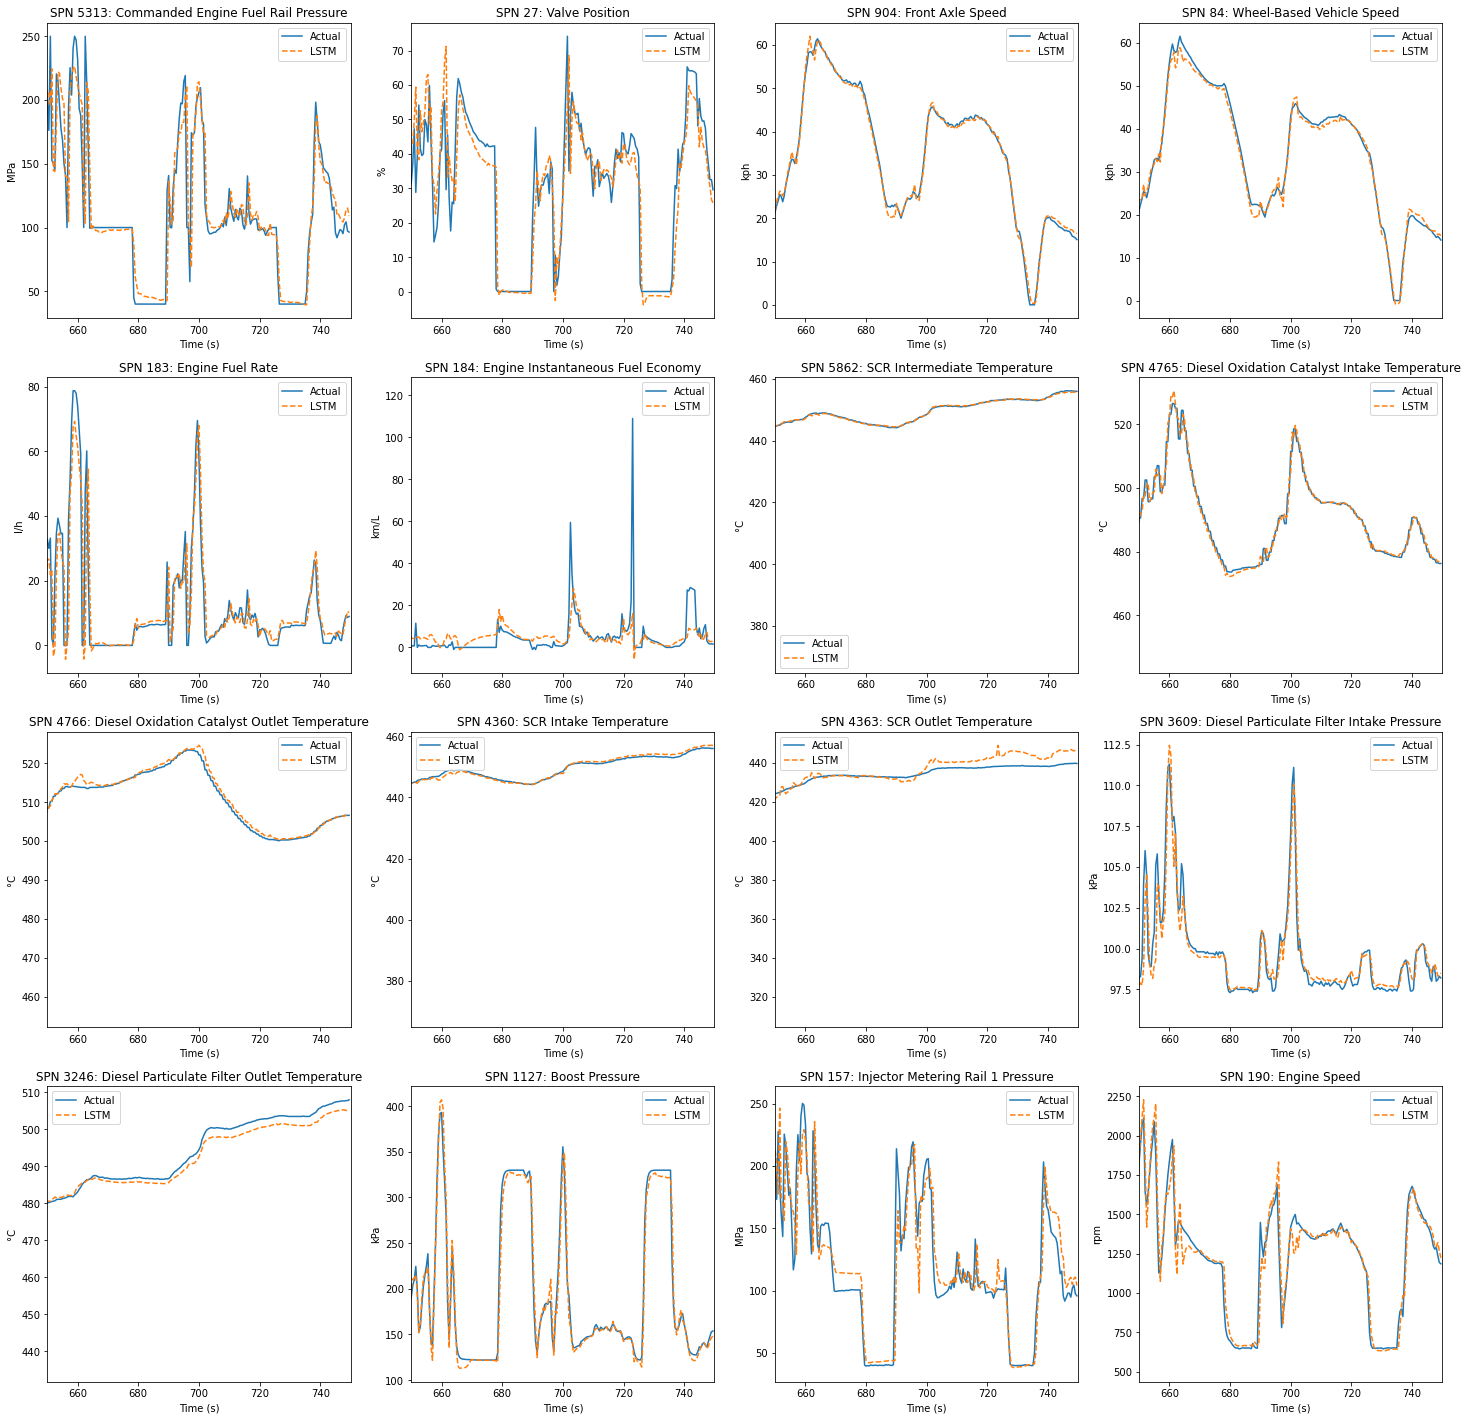

In [16]:
# Plot model prediction for validation sequence
plt.figure(figsize=(25,25))
i = 1
for spn in df_lstm:
    plt.subplot(4,4,i)
    i+=1
    # Plot actual data
    plt.plot(df[spn], label='Actual')
    # Plot model prediction
    plt.plot(np.arange(350.5, 750, 0.5), df_lstm[spn], '--', label='LSTM')
    plt.title(f'SPN {spn}: {get_SPN_name(spn)}')
    plt.xlabel('Time (s)')
    plt.ylabel(annex.loc[int(spn)]['Units'])
    plt.legend()
    # Only show validation sequence at end of data
    plt.xlim(650, 750)

## No-History LSTM Models

In [32]:
# Train a models with input excluding previous history
for spn in spns:
    tf.keras.backend.clear_session()
    model = lstm_model((1, len(df.columns)))
    filepath = f'models/LSTM_NOHIST_{spn}'
    print(f'Training model for SPN: {spn}')
    print(f'Save to {filepath}')
    train_model(model, df, df.columns.drop(spn), [spn], filepath)

Training model for SPN: 5313
Save to models/LSTM_NOHIST_5313
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5313/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5313/assets
Training model for SPN: 27
Save to models/LSTM_NOHIST_27
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_27/assets
INFO:tensor

INFO:tensorflow:Assets written to: models/LSTM_NOHIST_183/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_183/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_183/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_183/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_183/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_183/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_183/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_183/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_183/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_183/assets
Training model for SPN: 184
Save to models/LSTM_NOHIST_184
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_184/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_184/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_184/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_184/assets
Training model for SPN: 5862
Sa

INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5862/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_5862/assets
Training model for SPN: 4765
Save to models/LSTM_NOHIST_4765
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_4765/assets
INFO:tensorflow

INFO:tensorflow:Assets written to: models/LSTM_NOHIST_157/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_157/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_157/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_157/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_157/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_157/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_157/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_157/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_157/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_157/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_157/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_157/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_157/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_157/assets
INFO:tensorflow:Assets written to: models/LSTM_NOHIST_157/assets
Training model for SPN: 1

### No-History LSTM Model Predictions

In [34]:
# Evaluate models for each SPN
Ys = []
for spn in spns:
    filepath = f'models/LSTM_NOHIST_{spn}'
    
    # Generate model prediction
    tf.keras.backend.clear_session()
    Y = eval_model(df, df.columns.drop(spn), [spn], filepath)
    Ys.append(Y)

df_nh_lstm = pd.DataFrame(np.hstack(Ys), index=df.index[1:], columns=spns)

In [36]:
# Add LSTM predictions to our extrapolation dataframe
df_extrap = pd.concat([df_extrap, df_nh_lstm.set_axis(pd.MultiIndex.from_product([['No-Hist LSTM'],df_lstm.columns]), axis=1)], axis=1)

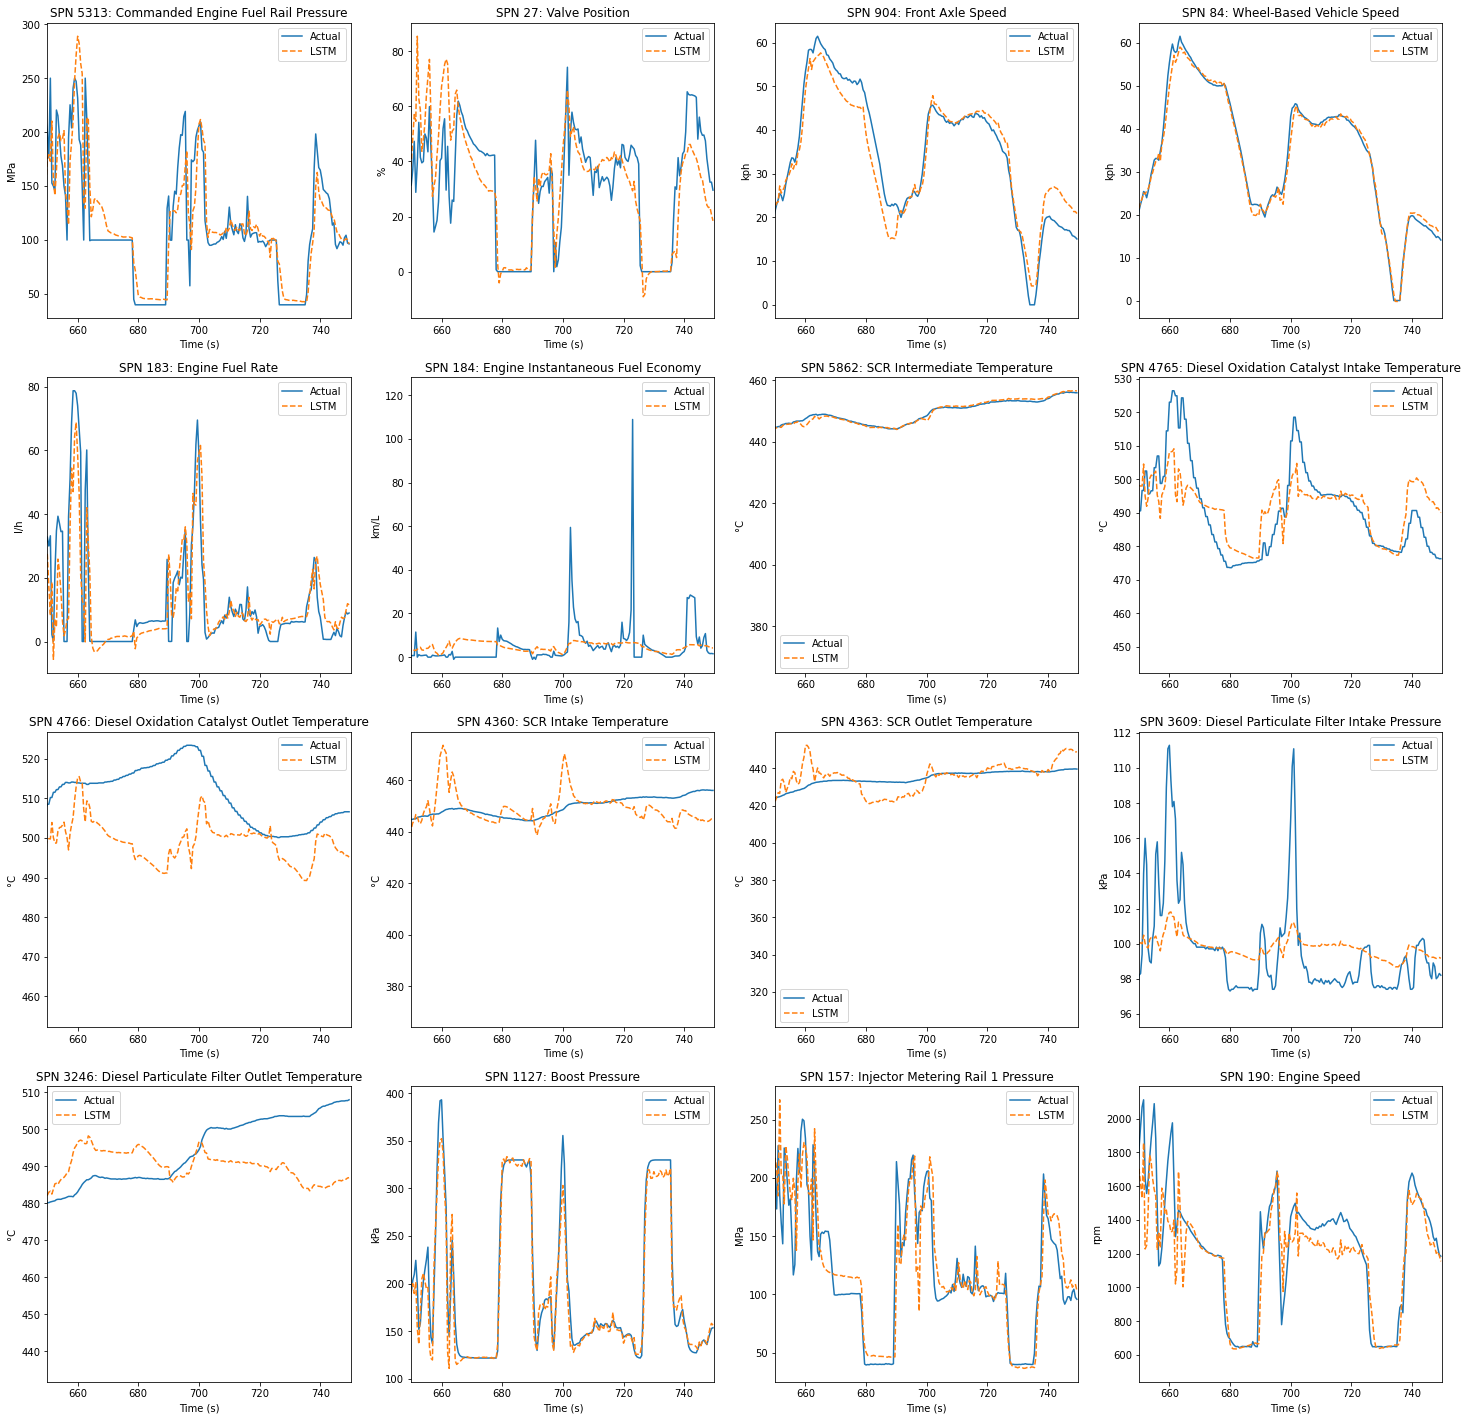

In [35]:
# Plot model prediction for validation sequence
plt.figure(figsize=(25,25))
i = 1
for spn in df_nh_lstm:
    plt.subplot(4,4,i)
    i+=1
    # Plot actual data
    plt.plot(df[spn], label='Actual')
    # Plot model prediction
    plt.plot(np.arange(350.5, 750, 0.5), df_nh_lstm[spn], '--', label='LSTM')
    plt.title(f'SPN {spn}: {get_SPN_name(spn)}')
    plt.xlabel('Time (s)')
    plt.ylabel(annex.loc[int(spn)]['Units'])
    plt.legend()
    # Only show validation sequence at end of data
    plt.xlim(650, 750)

## Evaluate Prediction Performance

### Pearson Correlation and RMSE

In [37]:
# We only conisder performance over the validation set
df_val = df_extrap.loc[650:750]

eval_list = []
methods = df_extrap.columns.levels[0].drop(['Actual'])
for method in methods:
    # Root mean squared error
    rmse = ((df_val['Actual'] - df_val[method])**2).mean()**0.5
    # Pearson Correlation
    corr = df_val['Actual'].corrwith(df_val[method], method='pearson')
    eval_list += [corr, rmse]
    
df_eval = pd.concat(eval_list, names=['Method', 'Metric'], keys=pd.MultiIndex.from_product([methods,['CORR','RMSE']]), axis=1)
df_eval

Method      LSTM               Linear             No-Hist LSTM              \
Metric      CORR       RMSE      CORR        RMSE         CORR        RMSE   
SPN                                                                          
5313    0.904404  23.200838  0.805539   38.759438     0.851079   28.764694   
27      0.903356   8.829811  0.848990   12.517670     0.809442   12.720588   
904     0.997933   0.971103  0.998541    0.821536     0.963112    4.248029   
84      0.996941   1.341467  0.998540    0.821140     0.995404    1.530904   
183     0.877499   8.333215  0.832867   12.265315     0.813904   10.108995   
184     0.542673   8.869453  0.326597   18.238848     0.206012   10.197672   
5862    0.997921   0.235165  0.998738    0.180365     0.990827    0.629795   
4765    0.987451   2.163801  0.960175    3.895186     0.723113    9.439401   
4766    0.994830   0.977214  0.996099    0.642971     0.193447   14.268269   
4360    0.994833   0.604557  0.998738    0.180365     0.000003    7.178600   
4363    0.954629   3.862238  0.998943    0.170439     0.516656    6.525053   
3609    0.945276   0.967154  0.944294    1.113979     0.764175    2.505674   
3246    0.998312   1.870136  0.999794    0.180317    -0.393710   11.803136   
1127    0.989367  11.834630  0.969126   22.020775     0.981903   16.200348   
157     0.918210  21.635406  0.901777   26.713432     0.892959   25.286169   
190     0.965843  94.724791  0.963840  104.809446     0.900806  169.447284   

Method     PCHIP                Repeat              
Metric      CORR        RMSE      CORR        RMSE  
SPN                                                 
5313    0.691272   52.754650  0.884440   26.000023  
27      0.724245   19.251536  0.909602    8.632277  
904     0.997457    1.080478  0.995460    1.424129  
84      0.997701    1.022441  0.995300    1.446658  
183     0.774724   14.128588  0.848693    9.566716  
184     0.221790   28.090574  0.440078   11.026527  
5862    0.997489    0.254070  0.998834    0.182126  
4765    0.960175    3.895186  0.978785    2.754313  
4766    0.996099    0.642971  0.998038    0.454649  
4360    0.997489    0.254070  0.998834    0.182126  
4363    0.997420    0.267671  0.999202    0.179369  
3609    0.925883    1.267643  0.927974    1.112048  
3246    0.999554    0.265829  0.999624    0.280293  
1127    0.956707   24.856332  0.952293   24.713720  
157     0.830780   36.153453  0.929738   20.452900  
190     0.941905  132.323458  0.959039  103.275268

### Violin Error Plots

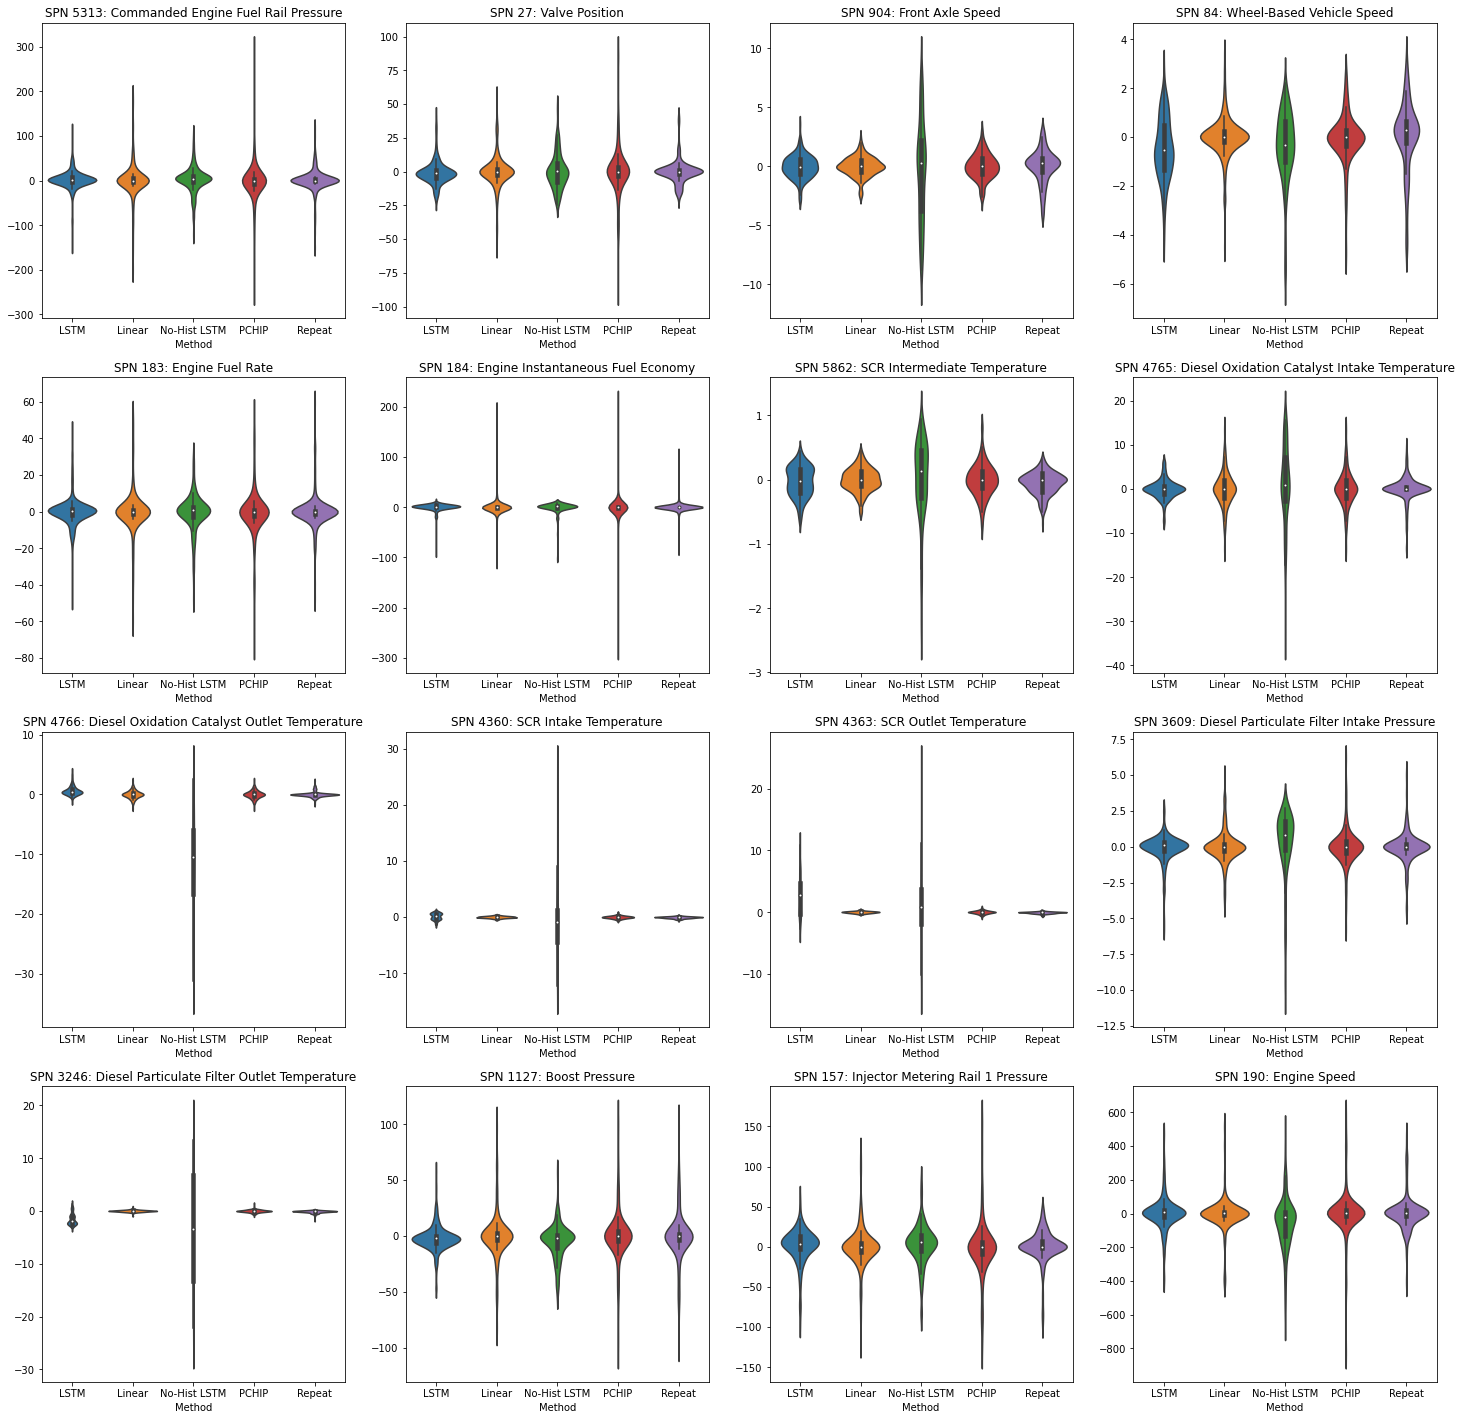

In [78]:
# Create dataframe of prediction errors
err_list = [(df_val[method] - df_val['Actual']) for method in methods]
df_err = pd.concat(err_list, keys=methods, axis=1)

# Construct violin Plots
fig, axes = plt.subplots(4, 4, figsize=(25, 25))
axes = axes.flatten()

for i, spn in enumerate(df_err.columns.levels[1]):
    sns.violinplot(data=df_err.xs(spn, level='SPN', axis=1), ax=axes[i])
    axes[i].set_title(f'SPN {spn}: {get_SPN_name(spn)}')

## Perturbation Analysis

In [111]:
def perturb_model(df, spn_in, spn_target, filepath, batch_size=50):
    '''Perform perturbation analysis to determine input importance to model'''
    # Normalize data
    scaler_in = MinMaxScaler()
    scaler_out = MinMaxScaler()

    scaled_in = scaler_in.fit_transform(df[spn_in])
    scaled_target = scaler_out.fit_transform(df[spn_target])

    # Load best weights
    model = tf.keras.models.load_model(filepath)
    
    results = []
    for spn in spn_in:
        print(f'Pertrubing model for SPN: {spn}')
        # Add random noise
        df_pert = df.copy()
        perturbation = np.random.normal(0, df_pert[spn].std() * 2, size=len(df_pert))
        df_pert[spn] = df_pert[spn] + perturbation
        
        # Create new test sequence
        pert_scaled_in = scaler_in.transform(df_pert)
        scaled_target = scaler_out.transform(df[spn_target])
        
        # Calculate train test data split
        test_split_index = int(len(scaled_target) * 0.75)
        
        pert_test_seq = tf.keras.preprocessing.sequence.TimeseriesGenerator(
            pert_scaled_in, scaled_target, 1, sampling_rate=1, stride=1, start_index=test_split_index,
            end_index=None, shuffle=False, reverse=False, batch_size=batch_size
        )

        # Evaluate perturbed test sequence
        pert_loss = model.evaluate(pert_test_seq)
        results.append(pert_loss)
        print(f'SPN: {spn} MSE: {pert_loss}')
    
    return results

In [112]:
# Perturb Models
df_pert = pd.DataFrame(index=spns)

for spn in spns:
    filepath = f'models/LSTM_{spn}'
    
    # Perturb Model
    tf.keras.backend.clear_session()
    results = perturb_model(df, df.columns, [spn], filepath)
    df_pert[spn] = results

Pertrubing model for SPN: 5313
4/4 [==============================] - 0s 2ms/step - loss: 0.0579
SPN: 5313 MSE: 0.057857733219861984
Pertrubing model for SPN: 27
4/4 [==============================] - 0s 2ms/step - loss: 0.0135
SPN: 27 MSE: 0.013479560613632202
Pertrubing model for SPN: 904
4/4 [==============================] - 0s 2ms/step - loss: 0.0172
SPN: 904 MSE: 0.017163826152682304
Pertrubing model for SPN: 84
4/4 [==============================] - 0s 2ms/step - loss: 0.0122
SPN: 84 MSE: 0.012165178544819355
Pertrubing model for SPN: 183
4/4 [==============================] - 0s 2ms/step - loss: 0.0501
SPN: 183 MSE: 0.050092414021492004
Pertrubing model for SPN: 184
4/4 [==============================] - 0s 2ms/step - loss: 0.0122
SPN: 184 MSE: 0.012190945446491241
Pertrubing model for SPN: 5862
4/4 [==============================] - 0s 2ms/step - loss: 0.0135
SPN: 5862 MSE: 0.01345468033105135
Pertrubing model for SPN: 4765
4/4 [==============================] - 0s 2ms/step - 

4/4 [==============================] - 0s 2ms/step - loss: 6.2571e-04
SPN: 1127 MSE: 0.0006257054628804326
Pertrubing model for SPN: 157
4/4 [==============================] - 0s 2ms/step - loss: 7.8985e-04
SPN: 157 MSE: 0.0007898511830717325
Pertrubing model for SPN: 190
4/4 [==============================] - 0s 2ms/step - loss: 0.0011
SPN: 190 MSE: 0.0010835303692147136
Pertrubing model for SPN: 5313
4/4 [==============================] - 0s 2ms/step - loss: 0.0119
SPN: 5313 MSE: 0.011867857538163662
Pertrubing model for SPN: 27
4/4 [==============================] - 0s 2ms/step - loss: 0.0126
SPN: 27 MSE: 0.012624231167137623
Pertrubing model for SPN: 904
4/4 [==============================] - 0s 2ms/step - loss: 0.0163
SPN: 904 MSE: 0.016263654455542564
Pertrubing model for SPN: 84
4/4 [==============================] - 0s 2ms/step - loss: 0.0120
SPN: 84 MSE: 0.012003610841929913
Pertrubing model for SPN: 183
4/4 [==============================] - 0s 2ms/step - loss: 0.0960
SPN: 18

4/4 [==============================] - 0s 2ms/step - loss: 0.0013
SPN: 4363 MSE: 0.0013345826882869005
Pertrubing model for SPN: 3609
4/4 [==============================] - 0s 2ms/step - loss: 7.1548e-04
SPN: 3609 MSE: 0.0007154805934987962
Pertrubing model for SPN: 3246
4/4 [==============================] - 0s 2ms/step - loss: 0.0013
SPN: 3246 MSE: 0.0012737474171444774
Pertrubing model for SPN: 1127
4/4 [==============================] - 0s 2ms/step - loss: 0.0025
SPN: 1127 MSE: 0.002496076049283147
Pertrubing model for SPN: 157
4/4 [==============================] - 0s 2ms/step - loss: 8.7831e-04
SPN: 157 MSE: 0.000878309307154268
Pertrubing model for SPN: 190
4/4 [==============================] - 0s 2ms/step - loss: 7.4400e-04
SPN: 190 MSE: 0.000744003220461309
Pertrubing model for SPN: 5313
4/4 [==============================] - 0s 2ms/step - loss: 1.9265e-04
SPN: 5313 MSE: 0.00019264958973508328
Pertrubing model for SPN: 27
4/4 [==============================] - 0s 2ms/step - l

4/4 [==============================] - 0s 2ms/step - loss: 0.0041
SPN: 4765 MSE: 0.004116853233426809
Pertrubing model for SPN: 4766
4/4 [==============================] - 0s 2ms/step - loss: 0.0042
SPN: 4766 MSE: 0.004150754306465387
Pertrubing model for SPN: 4360
4/4 [==============================] - 0s 2ms/step - loss: 0.0042
SPN: 4360 MSE: 0.004232893232256174
Pertrubing model for SPN: 4363
4/4 [==============================] - 0s 2ms/step - loss: 0.0043
SPN: 4363 MSE: 0.004275007639080286
Pertrubing model for SPN: 3609
4/4 [==============================] - 0s 2ms/step - loss: 0.0331
SPN: 3609 MSE: 0.03312036022543907
Pertrubing model for SPN: 3246
4/4 [==============================] - 0s 2ms/step - loss: 0.0045
SPN: 3246 MSE: 0.004490682389587164
Pertrubing model for SPN: 1127
4/4 [==============================] - 0s 2ms/step - loss: 0.0063
SPN: 1127 MSE: 0.006250966340303421
Pertrubing model for SPN: 157
4/4 [==============================] - 0s 2ms/step - loss: 0.0042
SPN: 

4/4 [==============================] - 0s 2ms/step - loss: 0.0036
SPN: 184 MSE: 0.003603729885071516
Pertrubing model for SPN: 5862
4/4 [==============================] - 0s 2ms/step - loss: 0.0035
SPN: 5862 MSE: 0.0035345552023500204
Pertrubing model for SPN: 4765
4/4 [==============================] - 0s 2ms/step - loss: 0.0037
SPN: 4765 MSE: 0.003661534981802106
Pertrubing model for SPN: 4766
4/4 [==============================] - 0s 2ms/step - loss: 0.0045
SPN: 4766 MSE: 0.004541401751339436
Pertrubing model for SPN: 4360
4/4 [==============================] - 0s 2ms/step - loss: 0.0037
SPN: 4360 MSE: 0.00370746455155313
Pertrubing model for SPN: 4363
4/4 [==============================] - 0s 2ms/step - loss: 0.0051
SPN: 4363 MSE: 0.005129990167915821
Pertrubing model for SPN: 3609
4/4 [==============================] - 0s 2ms/step - loss: 0.0047
SPN: 3609 MSE: 0.00469944579526782
Pertrubing model for SPN: 3246
4/4 [==============================] - 0s 2ms/step - loss: 0.0053
SPN: 

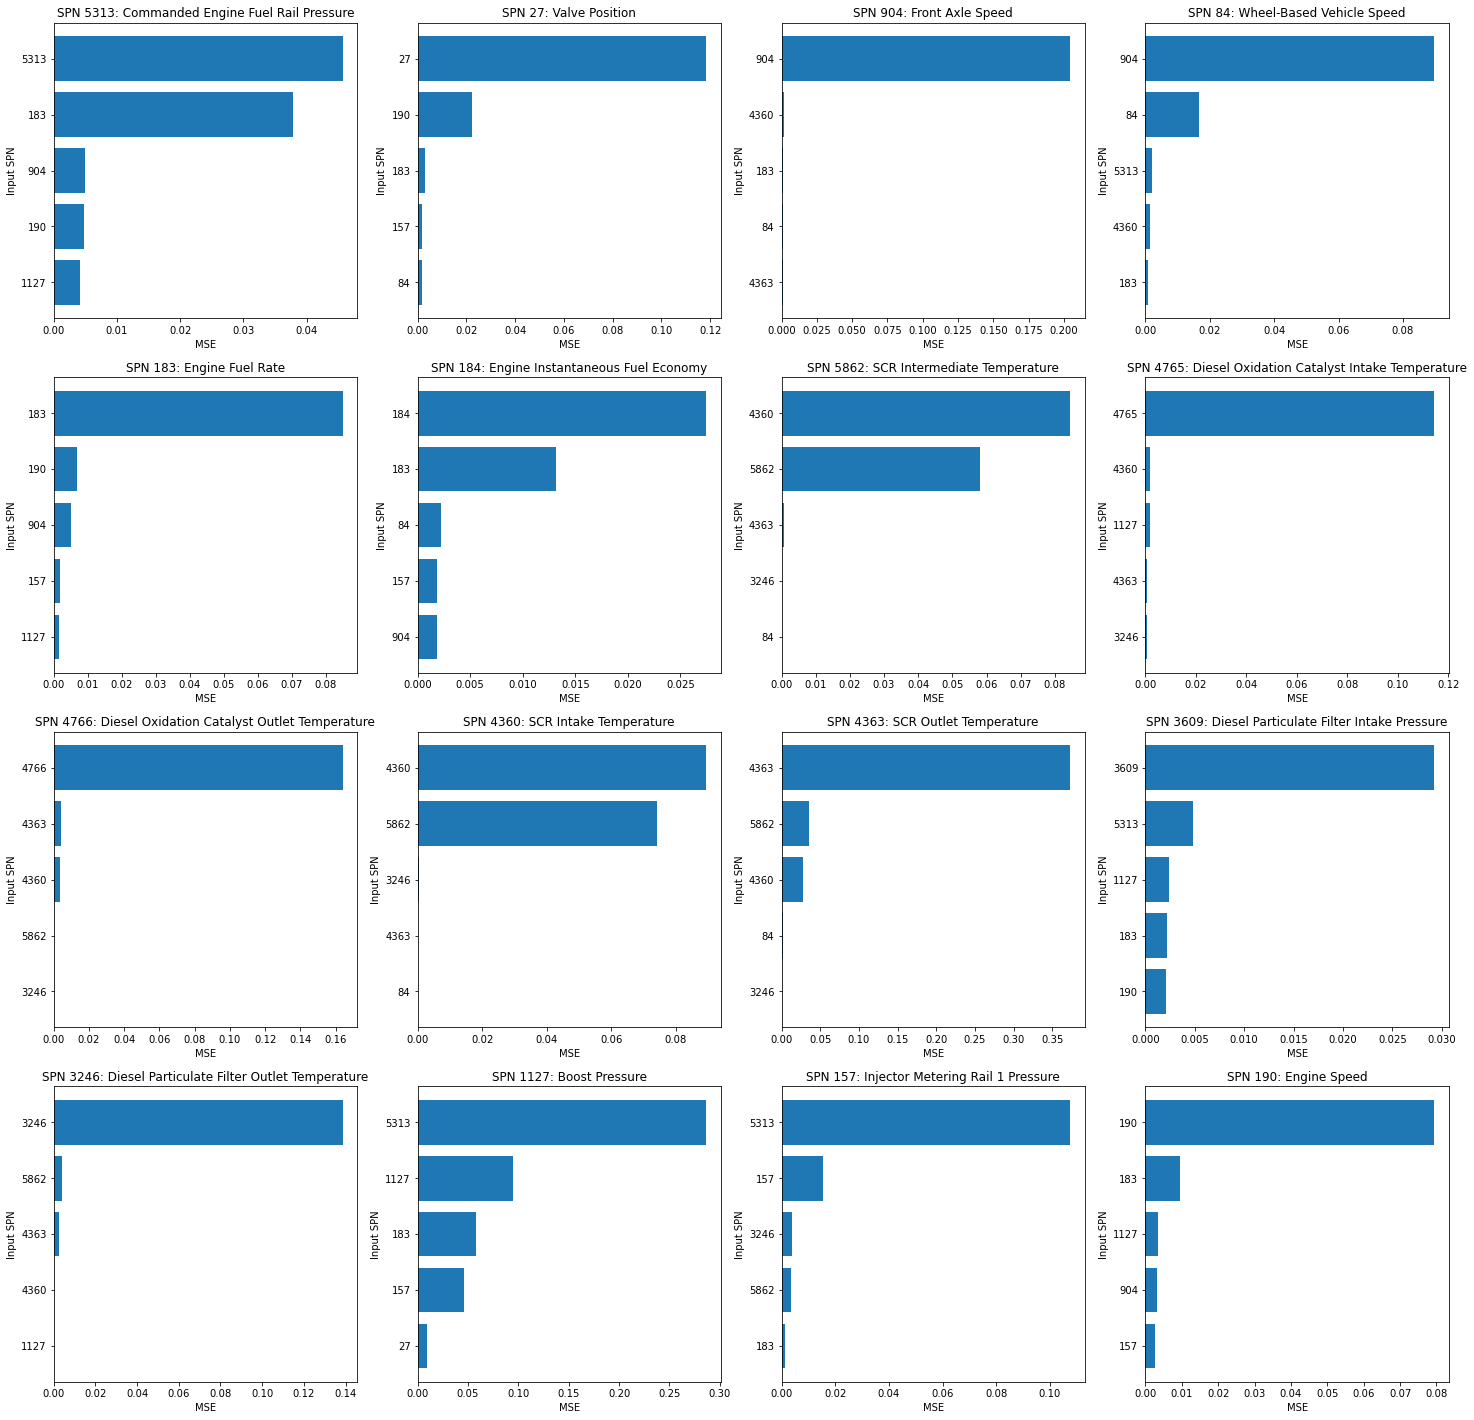

In [113]:
# Plot Perturbation results
fig = plt.figure(figsize=(25,25))
for i, spn in enumerate(df_pert):
    plt.subplot(4,4,i+1)
    y_labels = [textwrap.fill(label, 20) for label in top_5.index]
    # Plot top 5 most influential SPNs for this model
    top_5 = (df_pert[spn] - df_pert[spn].min()).sort_values(ascending=False).head(5)
    plt.barh(top_5.index, top_5.values)
    plt.gca().invert_yaxis()
    plt.title(f'SPN {spn}: {get_SPN_name(spn)}')
    plt.ylabel('Input SPN')
    plt.xlabel('MSE')